In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Î©îÎ™®Î¶¨ ÏÇ¨Ïö© Ï†úÌïúÏùÑ ÏúÑÌïú ÏÑ§Ï†ï
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # ÌäπÏ†ï GPUÎßå ÏÇ¨Ïö©ÌïòÎèÑÎ°ù ÏÑ§Ï†ï
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # ÌîÑÎ°úÍ∑∏Îû® ÏãúÏûë ÌõÑÏóêÎäî GPU ÏÑ§Ï†ïÏùÑ Î≥ÄÍ≤ΩÌï† Ïàò ÏóÜÏúºÎØÄÎ°ú
    # Îü∞ÌÉÄÏûÑ Ïò§Î•ò Î∞úÏÉù Ïãú ÏòàÏô∏ Ï≤òÎ¶¨Í∞Ä ÌïÑÏöîÌï®
        print(e)

Num GPUs Available:  1


## Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±

In [3]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from sklearn.preprocessing import LabelEncoder  # LabelEncoderÎ•º ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ ÏûÑÌè¨Ìä∏
from sklearn.model_selection import train_test_split  # train_test_splitÏùÑ ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ ÏûÑÌè¨Ìä∏
import os  # ÌååÏùº Î∞è ÎîîÎ†âÌÜ†Î¶¨ Í¥ÄÎ¶¨Î•º ÏúÑÌï¥ ÏûÑÌè¨Ìä∏
import cv2  # OpenCV ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ ÏûÑÌè¨Ìä∏
import numpy as np  # Î∞∞Ïó¥ Î∞è ÌñâÎ†¨ ÏûëÏóÖÏùÑ ÏúÑÌï¥ ÏûÑÌè¨Ìä∏
import matplotlib.pyplot as plt  # Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÏûÑÌè¨Ìä∏
import seaborn as sns  # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ Seaborn ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò Ï†ïÏùò
def load_data(data_directory):
    images = []  # Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    labels = []  # Î†àÏù¥Î∏î Îç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    classes = []  # ÌÅ¥ÎûòÏä§ Î™©Î°ùÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    label_encoder = LabelEncoder()  # LabelEncoder Í∞ùÏ≤¥ ÏÉùÏÑ±

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):  # ÎîîÎ†âÌÜ†Î¶¨Ïù∏ Í≤ΩÏö∞ÏóêÎßå Ï≤òÎ¶¨
            classes.append(class_name)

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)  # Ïù¥ÎØ∏ÏßÄ ÌååÏùº ÏùΩÍ∏∞
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGBÎ°ú Î≥ÄÌôò
                    img = cv2.resize(img, (224, 224))  # ÌÅ¨Í∏∞ Ï°∞Ï†ï
                    img = img / 255.0  # Ï†ïÍ∑úÌôî
                    images.append(img)  # Ïù¥ÎØ∏ÏßÄ Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
                    labels.append(class_name)  # Î†àÏù¥Î∏î Î¶¨Ïä§Ìä∏Ïóê ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ Ï∂îÍ∞Ä

    images = np.array(images)  # Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞Î•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    labels = label_encoder.fit_transform(labels)  # Î†àÏù¥Î∏îÏùÑ Ïà´ÏûêÎ°ú Î≥ÄÌôò
    classes = label_encoder.classes_  # ÌÅ¥ÎûòÏä§ Î™©Î°ùÏùÑ Ï†ÄÏû•

    return images, labels, classes

# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
train_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/Train'
train_images, train_labels, train_classes = load_data(train_data_directory)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
test_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/test'
test_images, test_labels, test_classes = load_data(test_data_directory)

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
valid_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/valid'
valid_images, valid_labels, valid_classes = load_data(valid_data_directory)

### Îç∞Ïù¥ÌÑ∞ÏÖãÎ≥Ñ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ÏÇ¥Ìé¥Î≥¥Í∏∞

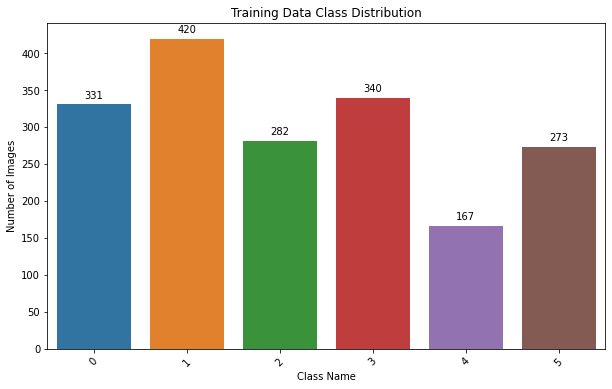

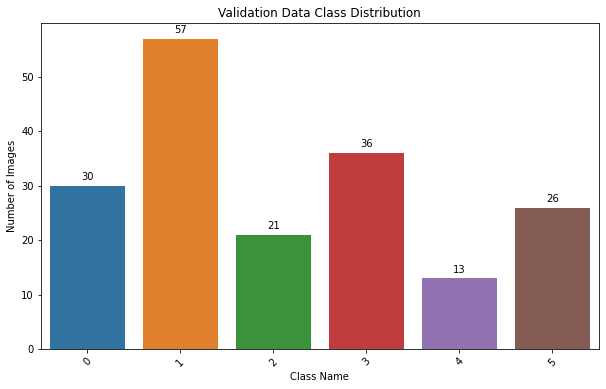

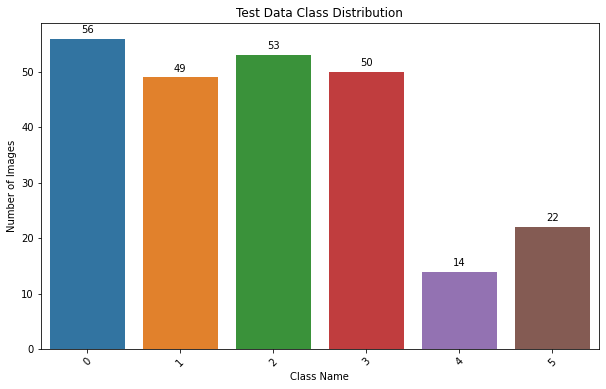

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÌÅ¥ÎûòÏä§Î≥Ñ Ïù¥ÎØ∏ÏßÄ Í∞úÏàò Í≥ÑÏÇ∞ Ìï®Ïàò
def plot_class_distribution(images, labels, title):
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    # ÎßâÎåÄ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x=class_counts.index, y=class_counts.values)
    
    # Í∞Å ÎßâÎåÄÏóê Ïà´Ïûê ÌëúÏãú
    for p in barplot.patches:
        barplot.annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')
    
    # Í∑∏ÎûòÌîÑ Ï†úÎ™© Î∞è Î†àÏù¥Î∏î ÏÑ§Ï†ï
    plt.title(title)
    plt.xlabel('Class Name')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)  # xÏ∂ï Î†àÏù¥Î∏î ÌöåÏ†Ñ
    plt.show()

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã ÏãúÍ∞ÅÌôî
plot_class_distribution(train_images, train_labels, 'Training Data Class Distribution')

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã ÏãúÍ∞ÅÌôî
plot_class_distribution(valid_images, valid_labels, 'Validation Data Class Distribution')

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã ÏãúÍ∞ÅÌôî
plot_class_distribution(test_images, test_labels, 'Test Data Class Distribution')

In [5]:
# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ïù¥ÎØ∏ÏßÄ shape ÌôïÏù∏
print("ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã(train_images) Ïù¥ÎØ∏ÏßÄÏùò shape:", train_images.shape)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Ïù¥ÎØ∏ÏßÄ shape ÌôïÏù∏
print("ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã(test_images) Ïù¥ÎØ∏ÏßÄÏùò shape:", test_images.shape)

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ïù¥ÎØ∏ÏßÄ shape ÌôïÏù∏
print("Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã(valid_images) Ïù¥ÎØ∏ÏßÄÏùò shape:", valid_images.shape)

ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã(train_images) Ïù¥ÎØ∏ÏßÄÏùò shape: (1813, 224, 224, 3)
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã(test_images) Ïù¥ÎØ∏ÏßÄÏùò shape: (244, 224, 224, 3)
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã(valid_images) Ïù¥ÎØ∏ÏßÄÏùò shape: (183, 224, 224, 3)


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï†úÎÑàÎ†àÏù¥ÌÑ∞ ÏÉùÏÑ±
datagen = ImageDataGenerator(
    rotation_range=30,         # Ïù¥ÎØ∏ÏßÄÎ•º ÎûúÎç§ÌïòÍ≤å 30ÎèÑ ÌöåÏ†Ñ
    width_shift_range=0.1,     # Í∞ÄÎ°úÎ°ú 10%ÍπåÏßÄ ÎûúÎç§ÌïòÍ≤å Ïù¥Îèô
    height_shift_range=0.1,    # ÏÑ∏Î°úÎ°ú 10%ÍπåÏßÄ ÎûúÎç§ÌïòÍ≤å Ïù¥Îèô
    shear_range=0.1,           # Î†àÏù¥Ïñ¥Î•º Î≥ÄÌòï
    zoom_range=0.3,            # 30% Î≤îÏúÑÎ°ú ÌôïÎåÄ ÎòêÎäî Ï∂ïÏÜå
    horizontal_flip=True,      # Í∞ÄÎ°úÎ°ú Îí§ÏßëÍ∏∞
    vertical_flip=True,        # ÏÑ∏Î°úÎ°ú Îí§ÏßëÍ∏∞
)

datagen1 = ImageDataGenerator()

# Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï†úÎÑàÎ†àÏù¥ÌÑ∞ ÏÉùÏÑ±
train_datagen = datagen.flow(train_images, train_labels, batch_size=20)
val_datagen = datagen1.flow(valid_images, valid_labels, batch_size=20)

### Îç∞Ïù¥ÌÑ∞ÏÖã Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî

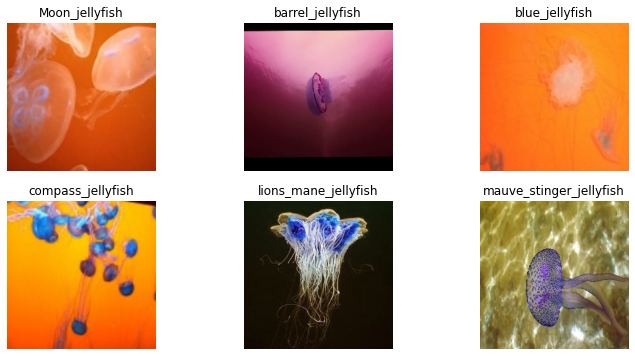

In [7]:
import random

# ÌÅ¥ÎûòÏä§Ïùò Ïù¥Î¶ÑÍ≥º ÏàòÎ•º ÌååÏïÖÌï©ÎãàÎã§.
class_names = train_classes  # train_imagesÏóêÏÑú train_classesÎ°ú Î≥ÄÍ≤Ω
num_classes = len(class_names)

# 1Ìñâ: ÌÅ¥ÎûòÏä§ Î≥ÑÎ°ú ÎûúÎç§Ìïú Ïù¥ÎØ∏ÏßÄ ÏÑ†ÌÉùÌïòÏó¨ Ï∂úÎ†•
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    class_images = train_images[train_labels == i]  # Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïùò Ïù¥ÎØ∏ÏßÄ Í∞ÄÏ†∏Ïò§Í∏∞
    if len(class_images) > 0:  # Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïóê Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
        random_index = random.randint(0, len(class_images) - 1)  # ÎûúÎç§Ìïú Ïù¥ÎØ∏ÏßÄ Ïù∏Îç±Ïä§ ÏÑ†ÌÉù
        selected_image = class_images[random_index]

        # Ïù¥ÎØ∏ÏßÄÎ•º Ï†ïÍ∑úÌôî Ìï¥Ï†úÌïòÏó¨ BGR ÏÉâÏÉÅÏúºÎ°ú Î≥ÄÌôò
        restored_image = selected_image * 255.0  # Ï†ïÍ∑úÌôîÎ•º Ìï¥Ï†úÌïòÍ∏∞ ÏúÑÌï¥ 255Î•º Í≥±Ìï©ÎãàÎã§.
        restored_image = restored_image.astype("uint8")  # Ï†ïÏàòÌòï Îç∞Ïù¥ÌÑ∞Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
        restored_image = cv2.cvtColor(restored_image, cv2.COLOR_RGB2BGR)  # RGBÏóêÏÑú BGRÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.

        plt.subplot(2, 3, i + 1)
        plt.imshow(restored_image)
        plt.title(class_names[i])  # ÌÅ¥ÎûòÏä§ Ïù¥Î¶ÑÏùÑ Ï†úÎ™©ÏúºÎ°ú ÌëúÏãú
        plt.axis("off")

plt.show()

# Î∞∞ÍπÖÏùÑ ÌôúÏö©Ìïú CNNÎ™®Îç∏ ÏïôÏÉÅÎ∏î

ü§î Î∞∞ÍπÖ(Bagging, Bootstrap Aggregating)

- Î™®Îç∏ÏùÑ ÏïôÏÉÅÎ∏îÌïòÎäî Î∞©Î≤ïÏ§ë ÌïòÎÇòÎ°ú ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ïó¨Îü¨Í∞úÏùò Bootstrap ÌëúÎ≥∏ÏùÑ Î¨¥ÏûëÏúÑ Ï∂îÏ∂úÌïòÏó¨ Í∞Å ÌëúÎ≥∏Ïóê ÎåÄÌï¥ classifierÎ•º ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú ÌõàÎ†®ÏãúÌÇµÎãàÎã§.
- Ïù¥ÌõÑ ÌõàÎ†®Îêú classifierÎì§Ïùò predictionÏùÑ Í≤∞Ìï©(voting)Ìï¥ÏÑú ÏµúÏ¢Ö predictionÏùÑ ÎßåÎì§Ïñ¥ ÎÉÖÎãàÎã§.

- CNNÎ™®Îç∏Ïùò ÏïôÏÉÅÎ∏îÎ°ú Î∞∞ÍπÖÏùÑ ÏÑ†ÌÉùÌïú Ïù¥Ïú†
    - CNNÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•òÏóê Îß§Ïö∞ Ìö®Í≥ºÏ†ÅÏù∏ ÏïåÍ≥†Î¶¨Ï¶ò ÏûÖÎãàÎã§.
    - ÌäπÌûà ÏßÄÏó≠Ï†Å Ìå®ÌÑ¥ÏùÑ Ïù∏ÏãùÌïòÎäîÎç∞ Îõ∞Ïñ¥ÎÇú Î™®Îç∏ÏûÖÎãàÎã§.
    - CNNÏùÑ Î∞∞ÍπÖÏóê Ï†ÅÏö©ÌïòÎ©¥ Í∞Å ÌëúÎ≥∏Ïóê ÎåÄÌï¥ CNNÏù¥ ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú ÌõàÎ†®Ïù¥ÎêòÍ≥†, ÌõàÎ†®Îêú Í∞Å CNNÎ™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Ï°∞Í∏àÏî© Îã§Î•∏ ÌäπÏÑúÏùÑ ÌïôÏäµÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Î™®Îç∏Ïùò ÏòàÏ∏°ÏùÑ Í≤∞Ìï©Ìï†Îïå Îçî Í∞ïÍ±¥Ìïú ÏµúÏ¢Ö ÏòàÏ∏°Ïù¥ Í∞ÄÎä•Ìï©ÎãàÎã§.
   - ÎòêÌïú, Ïù¥Î≤à DLthonÏóêÏÑú Í∞ÄÏû• ÌÅ∞ Î¨∏Ï†úÏòÄÎçò Îç∞Ïù¥ÌÑ∞Ïùò Í≥ºÏ†ÅÌï© Î∂ÄÎ∂ÑÏùÑ Î∞©ÏßÄÌïòÎäîÎç∞ Ïú†Ïö©ÌïòÎ©∞, predictionÏùò ÏïàÏ†ïÏÑ±ÏùÑ Ï∂îÍµ¨Ìï† Ïàò ÏûàÏäµÎãàÎã§.
   - Ïù¥Í≤ÉÏù¥ Í∞ÄÎä•Ìïú Ïù¥Ïú†Îäî Í∞Å classifierÍ∞Ä ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú ÌõàÎ†®ÎêòÏñ¥ errorÍ∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏóÜÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§.
   
---

- Îã§Îßå ÌòÑÏû¨Îäî Î™®Îëê Í∞ôÏùÄ ÌïôÏäµÎç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï¥ ÌïôÏäµÌïú Î™®Îç∏Ïù¥ÎØÄÎ°ú Î≥ÑÎèÑÏùò ÌïôÏäµÍ≥ºÏ†ïÏóÜÏù¥ PredictionÌïòÎäî Í≥ºÏ†ïÎßåÏùÑ Íµ¨ÌòÑÌï©ÎãàÎã§.

### Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞

In [8]:
from keras.models import load_model
import numpy as np

models = []

# Ï†ÄÏû•Îêú Î™®Îç∏ ÌååÏùº Î™©Î°ù
model_files = ['model/CNN_V2_adddata_best_model_epoch_130.h5', 'model/hj_cnn_model.h5', 'model/CNN_Best_Model_Acc_71_LSJ.h5']

# Î™®Îç∏Îì§ÏùÑ Î∂àÎü¨ÏôÄÏÑú Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•
models = [load_model(model_file) for model_file in model_files]

# Î™®Îç∏Îì§ÏùÑ Î∂àÎü¨Ïò§Í≥† Ïù¥Î¶ÑÏùÑ ÏÑ§Ï†ï
for model_file in model_files:
    model = load_model(model_file)
    model.custom_name = model_file.split('/')[-1]  # ÏÇ¨Ïö©Ïûê ÏßÄÏ†ï Ïù¥Î¶ÑÏúºÎ°ú ÏÑ§Ï†ï
    models.append(model)

### Prediction ÏàòÌñâ

In [9]:
def ensemble_predictions(models, test_images):
    # Í∞Å Î™®Îç∏Ïóê ÎåÄÌïú ÏòàÏ∏°Í∞íÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    predictions = []

    # Î™®Îì† Î™®Îç∏ÏùÑ ÏàúÌöåÌïòÎ©¥ÏÑú ÏòàÏ∏° ÏàòÌñâ
    for model in models:
        pred = model.predict(test_images)
        predictions.append(pred)

    # ÏòàÏ∏°Í∞íÎì§Ïùò ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞
    avg_predictions = np.mean(predictions, axis=0)
    
    return avg_predictions

# ÏïôÏÉÅÎ∏îÏùÑ ÌÜµÌïú ÏòàÏ∏° ÏàòÌñâ
ensemble_pred = ensemble_predictions(models, test_images)

# ÏµúÏ¢Ö ÏòàÏ∏° Í≤∞Í≥º
final_predictions = np.argmax(ensemble_pred, axis=1)

### Í≤∞Í≥º ÌèâÍ∞Ä

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ïã§Ï†ú ÌÖåÏä§Ìä∏ Î†àÏù¥Î∏îÍ≥º ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÏòàÏ∏° Í≤∞Í≥º ÎπÑÍµê
# Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
ensemble_accuracy = accuracy_score(test_labels, final_predictions)
print(f"Ï†ïÌôïÎèÑ: {ensemble_accuracy}")

# Ï†ïÎ∞ÄÎèÑ Í≥ÑÏÇ∞
ensemble_precision = precision_score(test_labels, final_predictions, average='macro')
print(f"Ï†ïÎ∞ÄÎèÑ: {ensemble_precision}")

# Ïû¨ÌòÑÏú® Í≥ÑÏÇ∞
ensemble_recall = recall_score(test_labels, final_predictions, average='macro')
print(f"Ïû¨ÌòÑÏú®: {ensemble_recall}")

# F1 Ï†êÏàò Í≥ÑÏÇ∞
ensemble_f1 = f1_score(test_labels, final_predictions, average='macro')
print(f"F1 Ï†êÏàò: {ensemble_f1}")

Ï†ïÌôïÎèÑ: 0.7418032786885246
Ï†ïÎ∞ÄÎèÑ: 0.7142171106937564
Ïû¨ÌòÑÏú®: 0.7163197337253941
F1 Ï†êÏàò: 0.7072219887985898


### Confusion Matrix

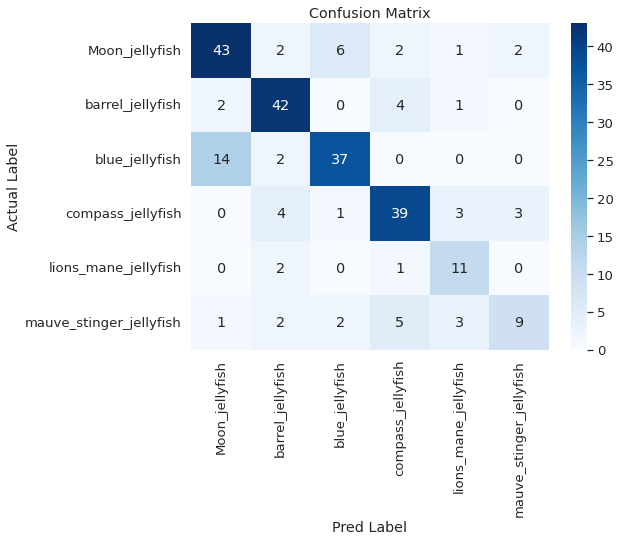

In [11]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ Í∞ÄÏ†∏Ïò§Í∏∞
import matplotlib.pyplot as plt
import seaborn as sns

# ÌòºÎèô ÌñâÎ†¨ ÏÉùÏÑ±
conf_matrix = confusion_matrix(test_labels, final_predictions)

# Í∑∏ÎûòÌîÑ Ïä§ÌÉÄÏùº ÏÑ§Ï†ï (ÏÑ†ÌÉùÏÇ¨Ìï≠)
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

# ÌòºÎèô ÌñâÎ†¨ ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,  # xÏ∂ï Î†àÏù¥Î∏îÏóê ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ ÏÇ¨Ïö©
            yticklabels=class_names)  # yÏ∂ï Î†àÏù¥Î∏îÏóê ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ ÏÇ¨Ïö©

# Í∑∏ÎûòÌîÑ Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title("Confusion Matrix")
plt.xlabel("Pred Label")
plt.ylabel("Actual Label")

# Í∑∏ÎûòÌîÑ ÌëúÏãú
plt.show()

### üí°ÏÑ±Îä• ÏßÄÌëú ÎπÑÍµê

- Í∞úÎ≥Ñ Î™®Îç∏Í≥º ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÏÑ±Îä• ÏßÄÌëú(Ï†ïÌôïÎèÑ, Ï†ïÎ∞ÄÎèÑ, Ïû¨ÌòÑÏú®, F1 Ï†êÏàò)Î•º ÎπÑÍµêÌï©ÎãàÎã§. 
- ÏïôÏÉÅÎ∏î Î™®Îç∏Ïù¥ Ïù¥Îü¨Ìïú ÏßÄÌëúÎì§ÏóêÏÑú Í∞úÎ≥Ñ Î™®Îç∏Îì§Î≥¥Îã§ Îçî ÎÜíÏùÄ ÏÑ±Îä•ÏùÑ Î≥¥Ïù∏Îã§Î©¥, Ïù¥Îäî ÏïôÏÉÅÎ∏î Î™®Îç∏Ïù¥ Îçî Ìö®Í≥ºÏ†ÅÏûÑÏùÑ ÎÇòÌÉÄÎÇº Ïàò ÏûàÏäµÎãàÎã§.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Í∞úÎ≥Ñ Î™®Îç∏Îì§Ïùò ÏÑ±Îä• ÏßÄÌëúÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
model_accuracies = []
model_precisions = []
model_recalls = []
model_f1s = []

# Í∞Å Î™®Îç∏Ïóê ÎåÄÌï¥ ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
for model in models:
    # ÏòàÏ∏° ÏàòÌñâ
    model_pred = model.predict(test_images)
    model_pred_classes = np.argmax(model_pred, axis=1)

    # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
    accuracy = accuracy_score(test_labels, model_pred_classes)
    precision = precision_score(test_labels, model_pred_classes, average='macro')
    recall = recall_score(test_labels, model_pred_classes, average='macro')
    f1 = f1_score(test_labels, model_pred_classes, average='macro')

    # Í≤∞Í≥º Ï†ÄÏû•
    model_accuracies.append(accuracy)
    model_precisions.append(precision)
    model_recalls.append(recall)
    model_f1s.append(f1)

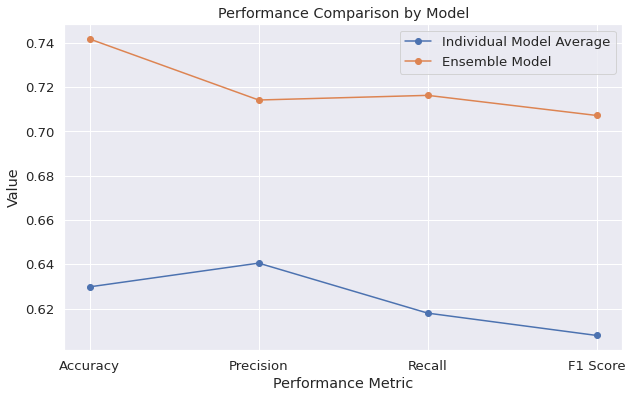

In [13]:
# ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÏÑ±Îä• ÏßÄÌëú
ensemble_metrics = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]

# Í∞úÎ≥Ñ Î™®Îç∏Îì§Ïùò ÌèâÍ∑† ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
average_metrics = [np.mean(model_accuracies), np.mean(model_precisions), np.mean(model_recalls), np.mean(model_f1s)]

# ÏÑ±Îä• ÏßÄÌëúÎ≥ÑÎ°ú Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]  # "Percision"ÏùÑ "Precision"ÏúºÎ°ú ÏàòÏ†ï
plt.figure(figsize=(10, 6))

plt.plot(metrics, average_metrics, label="Individual Model Average", marker='o')
plt.plot(metrics, ensemble_metrics, label="Ensemble Model", marker='o')

plt.title("Performance Comparison by Model")
plt.xlabel("Performance Metric")
plt.ylabel("Value")
plt.legend()
plt.show()

In [14]:
import pandas as pd

# Í∞úÎ≥Ñ Î™®Îç∏Ïùò ÏÑ±Îä• ÏßÄÌëúÎ•º Î¶¨Ïä§Ìä∏Î°ú Ï†ÄÏû•
individual_metrics = [
    ["Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† Ï†ïÌôïÎèÑ", np.mean(model_accuracies)],
    ["Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† Ï†ïÎ∞ÄÎèÑ", np.mean(model_precisions)],
    ["Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† Ïû¨ÌòÑÏú®", np.mean(model_recalls)],
    ["Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† F1 Ï†êÏàò", np.mean(model_f1s)]
]

# ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÏÑ±Îä• ÏßÄÌëúÎ•º Î¶¨Ïä§Ìä∏Î°ú Ï†ÄÏû•
ensemble_metrics = [
    ["ÏïôÏÉÅÎ∏î_Ï†ïÌôïÎèÑ", ensemble_accuracy],
    ["ÏïôÏÉÅÎ∏î_Ï†ïÎ∞ÄÎèÑ", ensemble_precision],
    ["ÏïôÏÉÅÎ∏î_Ïû¨ÌòÑÏú®", ensemble_recall],
    ["ÏïôÏÉÅÎ∏î_F1 Ï†êÏàò", ensemble_f1]
]

# Í∞úÎ≥Ñ Î™®Îç∏Í≥º ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÏÑ±Îä• ÏßÄÌëúÎ•º DataFrameÏúºÎ°ú ÏÉùÏÑ±
metrics_df = pd.DataFrame(individual_metrics + ensemble_metrics, columns=["ÏßÄÌëú", "Í∞í"])
metrics_df

ÏßÄÌëú         Í∞í
0    Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† Ï†ïÌôïÎèÑ  0.629781
1    Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† Ï†ïÎ∞ÄÎèÑ  0.640506
2    Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† Ïû¨ÌòÑÏú®  0.617907
3  Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∑† F1 Ï†êÏàò  0.607813
4         ÏïôÏÉÅÎ∏î_Ï†ïÌôïÎèÑ  0.741803
5         ÏïôÏÉÅÎ∏î_Ï†ïÎ∞ÄÎèÑ  0.714217
6         ÏïôÏÉÅÎ∏î_Ïû¨ÌòÑÏú®  0.716320
7       ÏïôÏÉÅÎ∏î_F1 Ï†êÏàò  0.707222

- ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò Î™®Îì† ÏÑ±Îä•ÌèâÍ∞ÄÏßÄÌëúÍ∞Ä Í∞úÎ≥ÑÎ™®Îç∏Ïùò ÌèâÍ∑†Î≥¥Îã§ Îçî ÎÜíÏùÄ Í∞íÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÏùåÏùÑ Ïïå Ïàò ÏûàÏäµÎãàÎã§.
- Ïù¥Îäî ÏïôÏÉÅÎ∏î Î™®Îç∏Ïù¥ Í∞úÎ≥Ñ Î™®Îç∏Îì§Ïóê ÎπÑÌï¥ Îçî Ï¢ãÏùÄ ÏÑ±Îä•ÏùÑ ÎÇòÌÉÄÎÇº Ïàò ÏûàÏùåÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.
- Îã§Îßå, Ïù¥ Í≤∞Í≥ºÎßåÏúºÎ°ú ÏïôÏÉÅÎ∏î Î™®Îç∏Ïù¥ Í≥ºÏ†ÅÌï©Ïóê Í∞ïÍ±¥Ìïú Î™®Îç∏Ïù∏ÏßÄÎ•º ÌåêÎã®Ìï† ÏàòÎäî ÏóÜÏäµÎãàÎã§.
- ÏïÑÎûòÏùò Í≥ºÏ†ÅÌï© ÌÖåÏä§Ìä∏Î•º ÌÜµÌï¥ Ìï¥Îãπ Î∂ÄÎ∂ÑÏùÑ ÌôïÏù∏Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

### Í≥ºÏ†ÅÌï© ÌÖåÏä§Ìä∏

- ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏôÄ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏÑ±Îä• Ï∞®Ïù¥Î•º ÎπÑÍµêÌï©ÎãàÎã§. 
- ÏïôÏÉÅÎ∏î Î™®Îç∏Ïù¥ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê ÎπÑÌï¥ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏÑ±Îä•Ïù¥ Îçú Îñ®Ïñ¥ÏßÑÎã§Î©¥, Ïù¥Îäî Í≥ºÏ†ÅÌï©Ïóê Îçú Ï∑®ÏïΩÌïòÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [15]:
import numpy as np
import gc
from sklearn.metrics import accuracy_score

def ensemble_predictions(models, images, batch_size=8):
    num_samples = len(images)
    num_batches = int(np.ceil(num_samples / batch_size))
    total_predictions = None

    for i in range(num_batches):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        batch_predictions = None

        for model in models:
            pred = model.predict(batch_images)
            if batch_predictions is None:
                batch_predictions = pred
            else:
                batch_predictions += pred

        batch_predictions /= len(models)

        if total_predictions is None:
            total_predictions = batch_predictions
        else:
            total_predictions = np.vstack((total_predictions, batch_predictions))

    return total_predictions


def evaluate_model_in_batches(predictions, labels, batch_size=32):
    num_samples = len(labels)
    num_batches = int(np.ceil(num_samples / batch_size))
    total_accuracy = 0

    for i in range(num_batches):
        batch_pred_classes = predictions[i*batch_size:(i+1)*batch_size]
        batch_labels = labels[i*batch_size:(i+1)*batch_size]

        # Î∞∞Ïπò Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
        batch_accuracy = accuracy_score(batch_labels, np.argmax(batch_pred_classes, axis=1))
        total_accuracy += batch_accuracy * len(batch_labels)

        # Î©îÎ™®Î¶¨ Ìï¥Ï†ú
        del batch_pred_classes, batch_labels
        gc.collect()

    # Ï†ÑÏ≤¥ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    overall_accuracy = total_accuracy / num_samples
    return overall_accuracy

#### ÏïôÏÉÅÎ∏î Î™®Îç∏ Í≥ºÏ†ÅÌï© ÌÖåÏä§Ìä∏

In [16]:
# Î™®Îç∏ ÌèâÍ∞ÄÎ•º ÏúÑÌïú Î∞∞Ïπò ÌÅ¨Í∏∞ ÏÑ§Ï†ï
batch_size = 16  # Î∞∞Ïπò ÌÅ¨Í∏∞Î•º 16ÏúºÎ°ú Ï§ÑÏûÑ

# ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÏòàÏ∏° Í≤∞Í≥º ÏÉùÏÑ±
ensemble_train_pred = ensemble_predictions(models, train_images)
ensemble_valid_pred = ensemble_predictions(models, valid_images)

# ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò ÌõàÎ†® Î∞è Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ ÌèâÍ∞Ä
ensemble_train_accuracy = evaluate_model_in_batches(ensemble_train_pred, train_labels, batch_size)
ensemble_valid_accuracy = evaluate_model_in_batches(ensemble_valid_pred, valid_labels, batch_size)

print("ÏïôÏÉÅÎ∏î Î™®Îç∏")
print(f"ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: {ensemble_train_accuracy}")
print(f"Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: {ensemble_valid_accuracy}\n")

ÏïôÏÉÅÎ∏î Î™®Îç∏
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.9773855488141202
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7704918032786885



#### Í∞úÎ≥ÑÎ™®Îç∏ Í≥ºÏ†ÅÌï© ÌÖåÏä§Ìä∏

In [17]:
# Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∞Ä
for model in models:
    # Í∞úÎ≥Ñ Î™®Îç∏Ïùò ÏòàÏ∏° Í≤∞Í≥º ÏÉùÏÑ±
    model_train_pred = model.predict(train_images)
    model_valid_pred = model.predict(valid_images)

    # Í∞úÎ≥Ñ Î™®Îç∏Ïùò ÌõàÎ†® Î∞è Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ ÌèâÍ∞Ä
    model_train_accuracy = evaluate_model_in_batches(model_train_pred, train_labels, batch_size)
    model_valid_accuracy = evaluate_model_in_batches(model_valid_pred, valid_labels, batch_size)

    print(f"Î™®Îç∏: {model.name}")
    print(f"ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: {model_train_accuracy}")
    print(f"Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: {model_valid_accuracy}\n")

    # Î©îÎ™®Î¶¨ Ìï¥Ï†ú
    del model_train_pred, model_valid_pred, model_train_accuracy, model_valid_accuracy
    gc.collect()

Î™®Îç∏: sequential_1
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.9884169884169884
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7814207650273224

Î™®Îç∏: sequential
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7010479867622724
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.46994535519125685

Î™®Îç∏: sequential
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.9349145063430778
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7540983606557377

Î™®Îç∏: sequential_1
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.9884169884169884
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7814207650273224

Î™®Îç∏: sequential
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7010479867622724
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.46994535519125685

Î™®Îç∏: sequential
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.9349145063430778
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑ: 0.7540983606557377



- Í∞úÎ≥Ñ Î™®Îç∏Ï§ë Í∞ÄÏû• ÎÜíÏùÄ ÏÑ±Îä•ÏùÑ ÏßÄÎãå Î™®Îç∏ÏùÄ equential_1ÏûÖÎãàÎã§.
- ÏïôÏÉÅÎ∏î Î™®Îç∏Ïùò Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÌôïÎèÑÍ∞Ä Í∞úÎ≥Ñ Î™®Îç∏ Ï§ë Í∞ÄÏû• ÎÜíÏùÄ ÏÑ±Îä•ÏùÑ Í∞ÄÏßÑ Î™®Îç∏Í≥º ÎπÑÏä∑Ìïú ÏàòÏ§ÄÏúºÎ°ú ÎÇòÌÉÄÎÇ©ÎãàÎã§. 
- Ïù¥Î°úÏç® ÏïôÏÉÅÎ∏î Î™®Îç∏ÏùÄ Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïòÍ≥†, Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑúÎèÑ Ï¢ãÏùÄ ÏÑ±Îä•ÏùÑ Î≥¥Ïó¨Ï£ºÍ≥† ÏûàÏùåÏùÑ Ïïå Ïàò ÏûàÏäµÎãàÎã§.
- ÏïôÏÉÅÎ∏î Î™®Îç∏ÏùÄ Ïó¨Îü¨ Í∞úÏùò Í∞úÎ≥Ñ Î™®Îç∏Ïùò ÏòàÏ∏°ÏùÑ ÌèâÍ∑†ÌôîÌïòÏó¨ Î≥¥Îã§ ÏùºÎ∞òÌôîÎêú ÏòàÏ∏°ÏùÑ Ï†úÍ≥µÌïòÎäî Îç∞ ÎèÑÏõÄÏù¥ Îê©ÎãàÎã§. 
- Îî∞ÎùºÏÑú ÏïôÏÉÅÎ∏î Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï®ÏúºÎ°úÏç® Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏóàÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.